<a href="https://colab.research.google.com/github/Helothlad/Monte-Carlo-simulations/blob/main/financial-growth-montecarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn numpy mplfinance requests pandas matplotlib beautifulsoup4 pandas_datareader yfinance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from bs4 import BeautifulSoup
import mplfinance as mpf
import sklearn
import matplotlib.dates as mdates
import datetime as dt
import yfinance as yf
from mplfinance.original_flavor import candlestick_ohlc
import bs4 as bs
import pickle
import requests
import os
from matplotlib import style
from collections import Counter
from sklearn import svm, neighbors, model_selection
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from dataclasses import dataclass
import random
style.use('ggplot')

In [ ]:
@dataclass
class SimulationInputs:
    n_iterations: int = 100
    starting_salary: float = 50000
    starting_salary_std: float = 10000
    promos_every_n_years: float = 3
    promos_every_n_years_std: float = 1.5
    promo_raise: float = 0.10
    promo_raise_std: float = 0.05
    cost_of_living_raise: float = 0.02
    cost_of_living_raise_std: float = 0.005
    savings_rate: float = 0.20
    savings_rate_std: float = 0.07
    interest_rate: float = 0.05
    interest_rate_std: float = 0.01
    desired_cash: float = 1000000

In [ ]:
def random_normal_positive(mean, std):
  drawn_value = -1
  while drawn_value < 0:
    drawn_value = random.normalvariate(mean, std)
  return drawn_value

In [ ]:
def years_to_retirement_simulation_inputs(data: SimulationInputs):
    starting_salary = random_normal_positive(data.starting_salary, data.starting_salary_std)
    promos_every_n_years = max(
        1,
        int(round(random_normal_positive(data.promos_every_n_years, data.promos_every_n_years_std)))
    )
    cost_of_living_raise = random_normal_positive(data.cost_of_living_raise, data.cost_of_living_raise_std)
    promo_raise = random_normal_positive(data.promo_raise, data.promo_raise_std)
    savings_rate = min(1.0, random_normal_positive(data.savings_rate, data.savings_rate_std))  # capped at 100%
    interest_rate = max(0.0, random_normal_positive(data.interest_rate, data.interest_rate_std))

    return SimulationInputs(
        starting_salary=starting_salary,
        promos_every_n_years=promos_every_n_years,
        cost_of_living_raise=cost_of_living_raise,
        promo_raise=promo_raise,
        savings_rate=savings_rate,
        interest_rate=interest_rate,
        desired_cash=data.desired_cash,
        n_iterations=data.n_iterations
    )


In [ ]:
def years_to_retirement(data: SimulationInputs):
    wealth = 0
    salary = data.starting_salary
    year = 0

    print("Wealth over time:")

    while wealth < data.desired_cash:
        year += 1

        # Apply promotion every N years
        if year % int(round(data.promos_every_n_years)) == 0:
            salary *= (1 + data.promo_raise)

        # Apply cost-of-living raise
        salary *= (1 + data.cost_of_living_raise)

        # Save part of salary
        savings = salary * data.savings_rate
        wealth += savings  # accumulate savings

        # Apply interest to accumulated wealth
        wealth *= (1 + data.interest_rate)

        # Safety stop
        if year > 100:
            print("Retirement goal not reached in 100 years.")
            return None

    print(f"Reached desired wealth of {data.desired_cash:,.0f} in {year} years!")
    return (
        year,
        data.starting_salary,
        data.promos_every_n_years,
        data.cost_of_living_raise,
        data.promo_raise,
        data.savings_rate,
        data.interest_rate,
        )

In [ ]:
def years_to_retirement_mc(data):
  all_results = []
  for i in range(data.n_iterations):
      sim_data = years_to_retirement_simulation_inputs(SimulationInputs())
      result = years_to_retirement(sim_data)
      all_results.append(result)
  df = pd.DataFrame(
      all_results,
      columns=[
          'Years to Retirement',
          'Starting Salary',
          'Promos Every N Years',
          'Cost of Living Raise',
          'Promotion Raise',
          'Savings Rate',
          'Interest Rate'
      ]
  )
  return df

In [ ]:
years_to_retirement_mc(SimulationInputs(n_iterations=10000))

Streaming output truncated to the last 5000 lines.
Wealth over time:
Reached desired wealth of 1,000,000 in 24 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 29 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 22 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 22 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 37 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 26 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 30 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 27 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 21 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 16 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 27 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 22 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 25 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 54 years!
Wealth over

,Years to Retirement,Starting Salary,Promos Every N Years,Cost of Living Raise,Promotion Raise,Savings Rate,Interest Rate
0,33.0,47349.386720,5.0,0.013297,0.031237,0.272017,0.034134
1,27.0,60037.093612,4.0,0.008016,0.096502,0.192560,0.055123
2,30.0,46139.875010,4.0,0.019800,0.065627,0.208867,0.047821
3,23.0,59751.453154,5.0,0.023809,0.015701,0.320840,0.046855
4,25.0,38003.503182,1.0,0.017777,0.061424,0.213478,0.052070
...,...,...,...,...,...,...,...
9995,25.0,44328.259351,4.0,0.017568,0.171715,0.269397,0.042176
9996,21.0,54010.100318,3.0,0.018571,0.156812,0.308172,0.039646
9997,31.0,46899.847453,6.0,0.021919,0.106311,0.182537,0.052237
9998,21.0,64117.012741,5.0,0.026845,0.115837,0.259039,0.056768


In [ ]:
def plot_retirement_years(df, column='Years to Retirement'):
    """
    Plots a histogram of years to retirement from a DataFrame
    and marks the mean with a vertical line.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the Monte Carlo results.
    column : str, optional
        The column name with years to retirement (default is 'Years to Retirement').
    """
    # Drop NaN (cases where retirement goal wasn't reached)
    valid_years = df[column].dropna()
    mean_year = valid_years.mean()

    plt.figure(figsize=(10, 6))
    plt.hist(valid_years, bins=60, alpha=0.7)
    plt.axvline(mean_year, linewidth=2, label=f'Mean = {mean_year:.2f} years')

    plt.title('Histogram of Years to Retirement (Monte Carlo)')
    plt.xlabel('Years to Retirement')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

Streaming output truncated to the last 5000 lines.
Wealth over time:
Reached desired wealth of 1,000,000 in 25 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 32 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 22 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 22 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 35 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 31 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 27 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 25 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 35 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 38 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 18 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 32 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 25 years!
Wealth over time:
Reached desired wealth of 1,000,000 in 21 years!
Wealth over

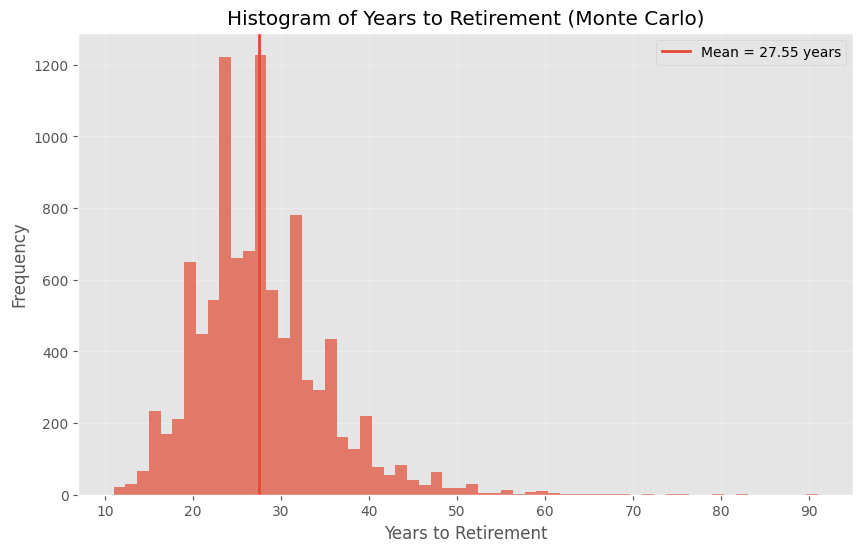

In [ ]:
df = years_to_retirement_mc(SimulationInputs(n_iterations=10000))
plot_retirement_years(df)
